In [143]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [144]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229
from imports import *
from loading import load_session_data
from target import get_spike_counts, build_tgt_matrix, build_silence_matrix
from scipy import stats
from scipy import signal
import pandas as pd
from functools import reduce
from statsmodels.formula.api import ols, glm
from postprocessing.spiketrain import instantaneous_rate

In [145]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [146]:
#selected_009266
selected_008229

['008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-20_15-54-39',
 '008229_hippoSIT_2022-05-18_14-36-18']

## Loading

In [147]:
session = selected_008229[0]
session = selected_009266[4]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009266_hippoSIT_2023-04-20_08-57-39'

In [148]:
animal     = session.split('_')[0]
moseq_file = os.path.join(source, animal, session, 'moseq.h5')

with h5py.File(moseq_file, 'r') as f:
    moseq_matrix  = np.array(f['moseq'])
    moseq_headers = f['moseq'].attrs['headers']
    
moseq_headers = moseq_headers.split(',')
moseq_headers = [moseq_headers[0]] + [x[1:] for x in moseq_headers[1:]]

# reindex from 1
moseq = pd.DataFrame(moseq_matrix, columns=moseq_headers)
moseq['syllables reindexed'] = moseq['syllables reindexed'] + 1  

# smooth latent states
k_width = 200  # for 100Hz timeline it's 0.5 second
kernel = signal.gaussian(k_width, std=(k_width) / 7.2)

l_state_cols = [x for x in moseq.columns if x.find('latent_state') >= 0]
for l_state_name in l_state_cols:
    moseq[l_state_name] = np.convolve(moseq[l_state_name], kernel, 'same') / kernel.sum()
    
moseq.head()

,syllables reindexed,syllables non-reindexed,centroid x,centroid y,heading,estimated left_eye x,estimated left_eye y,estimated right_eye x,estimated right_eye y,estimated left_ear x,...,estimated right_hip y,latent_state 0,latent_state 1,latent_state 2,latent_state 3,latent_state 4,latent_state 5,latent_state 6,latent_state 7,latent_state 8
0,5.0,54.0,0.330473,-0.200610,-2.7413,0.322966,-0.195349,0.317858,-0.192779,0.346771,...,-0.203844,-0.162765,-0.037246,0.682169,0.017540,-0.141217,-0.552123,-0.431188,-0.162225,-0.689408
1,5.0,54.0,0.330473,-0.200610,-2.7413,0.322966,-0.195349,0.317858,-0.192779,0.346771,...,-0.203844,-0.163125,-0.044080,0.701706,0.020699,-0.143438,-0.567235,-0.444699,-0.167619,-0.703944
2,5.0,54.0,0.338817,-0.200188,-2.4909,0.284522,-0.191278,0.334487,-0.178966,0.317854,...,-0.189377,-0.163223,-0.051186,0.721159,0.024023,-0.145598,-0.582290,-0.458204,-0.172976,-0.718059
3,5.0,54.0,0.338817,-0.200188,-2.4909,0.284522,-0.191278,0.334487,-0.178966,0.317854,...,-0.189377,-0.163057,-0.058557,0.740496,0.027508,-0.147695,-0.597263,-0.471680,-0.178274,-0.731717
4,5.0,54.0,0.338817,-0.200188,-2.4909,0.284522,-0.191278,0.334487,-0.178966,0.317854,...,-0.189377,-0.162616,-0.066180,0.759684,0.031157,-0.149735,-0.612138,-0.485106,-0.183502,-0.744889


## Syllable distribution

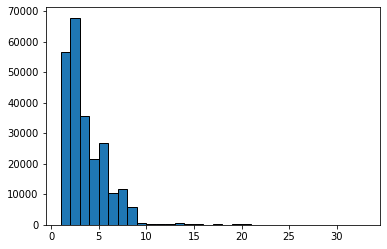

In [149]:
sr = moseq['syllables reindexed']
_ = plt.hist(sr, bins=len(sr.unique()) + 1, edgecolor='black')

## Sylables ratio matrix

In [159]:
win_l   = 2    # seconds
step    = 1    # seconds
s_rate  = 100  # Hz
syl_num = 10

idxs_srm_tl = np.arange(0, len(tl), int(step*s_rate))
syl_ratio_matrix = np.zeros([len(idxs_srm_tl), syl_num])

for i, idx in enumerate(idxs_srm_tl):
    curr_syls = moseq['syllables reindexed'][idx:idx + int(win_l*s_rate)]
    for j in np.arange(syl_num):
        syl_ratio_matrix[i, j] = np.sum(curr_syls == j+1) / (win_l*s_rate)

## Syllable timeline

In [151]:
# unit to plot
unit_name = '3-15'
#i_rate        = instantaneous_rate(spike_times[unit_name], tl[:, 0], k_width=50)
i_rate        = single_units[unit_name]
i_rate_normed = i_rate / (i_rate.max()/10)
thresh        = i_rate.mean()
th_normed     = thresh / (i_rate.max()/10)

# latent states to plot
l_state        = np.array(moseq['latent_state 0'])
l_state[l_state > 4*l_state.std()] = 4*l_state.std()
l_state_normed = l_state / (l_state.max()/10)

In [152]:
# reading syllables
syls = np.array(moseq['syllables reindexed'])
syls_t = np.linspace(tl[:, 0][0], tl[:, 0][-1], len(syls))

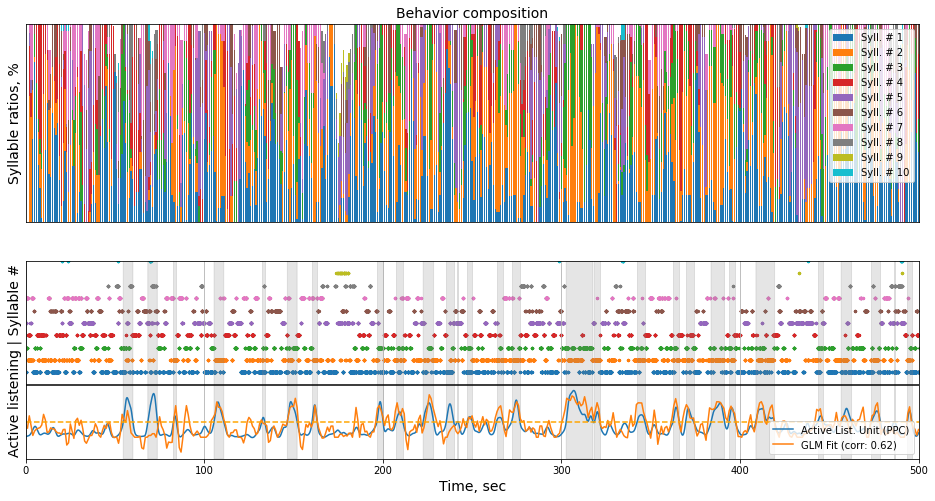

In [162]:
t1, t2 = 0, 500
syls_filt = np.where(syls == 0)[0]

colors_bold = [plt.cm.tab20(2*i) for i in range(10)]
colors_tran = [plt.cm.tab20(2*i + 1) for i in range(10)]
colors = colors_bold + colors_tran

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# syllable ratios
ax = axes[0]
idxs_to_idxs = np.where((tl[idxs_srm_tl][:, 0] > t1) & (tl[idxs_srm_tl][:, 0] < t2))[0]
idxs_sel = idxs_srm_tl[idxs_to_idxs]
bottom = np.zeros(len(idxs_sel))
for i, syl_ratio in enumerate(syl_ratio_matrix[idxs_to_idxs].T):
    ax.bar(tl[idxs_sel][:, 0] + step, syl_ratio, 0.7, bottom=bottom, label='Syll. # %s' % str(i+1))
    bottom += syl_ratio
ax.set_xlim(t1, t2)
ax.set_title('Behavior composition', fontsize=14)
ax.set_ylabel('Syllable ratios, %', fontsize=14)
ax.legend(loc='upper right')
ax.set_xticks([])
ax.set_yticks([])

# syllables
syl_count = 10
ax = axes[1]
for i in range(syl_count):
    idxs = np.where(syls == i + 1)[0]
    ax.scatter(syls_t[idxs], syls[idxs], s=5, color=colors[i])

#glm_coeffs = {1: 6.05, 2: 7.06, 6: -6.46, 7: 3.09, 8: 14.79}  # idx / coeff for GLM fit for AL
glm_coeffs = dict([(i, coef) for i, coef in enumerate(model.params[1:]) if model.pvalues[1:][i] < 0.01])
behav_fit = np.zeros(len(syl_ratio_matrix))
for idx, coef in glm_coeffs.items():
    behav_fit += coef * syl_ratio_matrix[:, idx]
#corr, pval = stats.pearsonr(behav_fit[-600:], i_rate[idxs_srm_tl][-600:])
corr, pval = stats.pearsonr(behav_fit, i_rate[idxs_srm_tl])

# firing rates
#ax.scatter(syls_t[syls_filt], syls[syls_filt], s=5, color='red')
#ax.plot(tl[:, 0], l_state_normed - l_state_normed.max())
#ax.plot(tl[:, 0], i_rate_normed - i_rate_normed.max(), label='Active List. Unit (PPC)')
ax.plot(tl[:, 0], stats.zscore(i_rate_normed) - 3, label='Active List. Unit (PPC)')
#ax.plot(tl[idxs_srm_tl][:, 0] + step, 10*syl_ratio_matrix[:, 1:3].sum(axis=1) - 10, label='Syll. 2+3')
ax.plot(tl[idxs_srm_tl][:, 0] + step, stats.zscore(behav_fit) - 3, label='GLM Fit (corr: %.2f)' % corr)
ax.fill_between(tl[:, 0], 0, 10, where=i_rate > thresh, color='grey', alpha=0.2, transform=ax.get_xaxis_transform())
ax.grid()
ax.axhline(0, color='black')
ax.axhline(stats.zscore(i_rate_normed).mean() - 3, color='orange', ls='--')
ax.set_xlim(t1, t2)
ax.set_ylim(-6, syl_count)
ax.set_ylabel('Active listening | Syllable #', fontsize=14)
ax.set_xlabel('Time, sec', fontsize=14)
ax.legend(loc='lower right')
ax.set_yticks([])

#fig.tight_layout()
fig.savefig(os.path.join(report_path, 'behav_comp_in_time_%s.png' % session[:26]))

## GLM

In [155]:
def get_shuffled(spiketrain, duration=2400):
    rand_times = np.random.rand(len(spiketrain)) * duration
    return (spiketrain + rand_times) % duration

In [160]:
unit_name = '3-15'
i_rate        = single_units[unit_name]  # orignal smoothing
#i_rate        = instantaneous_rate(spike_times[unit_name], tl[:, 0], k_width=50)  # more precise
#i_rate = instantaneous_rate(get_shuffled(single_units[unit_name]), tl[:, 0])
i_rate_binned = i_rate[idxs_srm_tl]

# syllable ratios
data = np.column_stack([i_rate_binned, syl_ratio_matrix])
columns = ['state'] + ["x%d" % x for x in range(syl_ratio_matrix.shape[1])]
syl_ratio_df = pd.DataFrame(data, columns=columns)
syl_ratio_df.head()

,state,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.585146,0.100,0.320,0.085,0.135,0.110,0.00,0.250,0.0,0.0,0.0
1,0.830476,0.000,0.635,0.000,0.255,0.065,0.00,0.045,0.0,0.0,0.0
2,1.249853,0.000,0.530,0.000,0.120,0.065,0.00,0.285,0.0,0.0,0.0
3,2.394622,0.420,0.245,0.000,0.000,0.000,0.05,0.285,0.0,0.0,0.0
4,4.336990,0.805,0.030,0.115,0.000,0.000,0.05,0.000,0.0,0.0,0.0


In [161]:
model = glm('state ~ ' + ' + '.join(columns[1:]), data=syl_ratio_df[:]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  state   No. Observations:                 2400
Model:                            GLM   Df Residuals:                     2389
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                          25.893
Method:                          IRLS   Log-Likelihood:                -7304.7
Date:                Wed, 27 Sep 2023   Deviance:                       61857.
Time:                        10:35:52   Pearson chi2:                 6.19e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4856
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0827      2.431      1.679      0.093      -0.682       8.848
x0            -0.9914      2.476     -0.400      0.689      -5.844       3.861
x1            11.2298      2.445      4.594      0.000       6.438      16.021
x2            14.2585      2.480      5.748      0.000       9.397      19.120
x3            -2.6882      2.530     -1.063      0.288      -7.646       2.270
x4            -0.4739      2.566     -0.185      0.853      -5.503       4.555
x5            -2.7853      2.701     -1.031      0.303      -8.080       2.509
x6            -7.6563      2.605     -2.939      0.003     -12.762      -2.550
x7             5.7537      2.859      2.012      0.044       0.150      11.357
x8            -1.5810      8.289     -0.191      0.849     -17.827      14.665
x9            20.5665      9.874      2.083      0.037       1.213      39.920
==============================================================================
"""

## PCA on syllable ratios

In [19]:
from sklearn import decomposition

fet_matrix = syl_ratio_matrix

pca = decomposition.PCA(n_components=10)
pca.fit(fet_matrix)
X = pca.transform(fet_matrix)

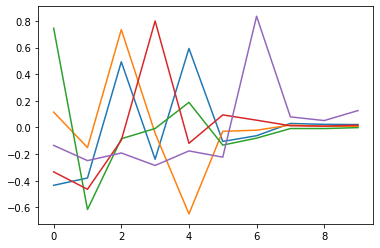

In [30]:
fig, ax = plt.subplots(1, 1)
ax.plot(pca.components_[0])
ax.plot(pca.components_[1])
ax.plot(pca.components_[2])
ax.plot(pca.components_[3])
ax.plot(pca.components_[4])

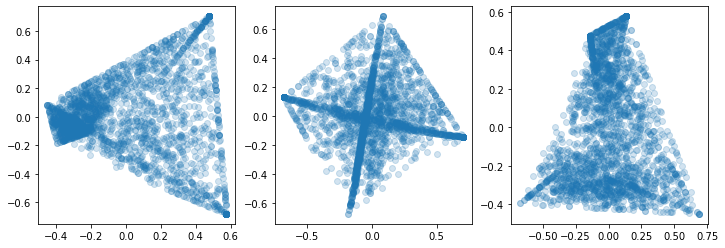

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
axes[1].scatter(X[:, 1], X[:, 2], alpha=0.2)
axes[2].scatter(X[:, 2], X[:, 0], alpha=0.2)

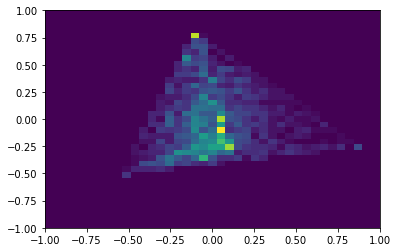

In [54]:
fig, ax = plt.subplots(1, 1)
_ = ax.hist2d(X[:, 2], X[:, 0], bins=[np.linspace(-1, 1, 40), np.linspace(-1, 1, 40)])

## Latent state correlations

In [22]:
unit_name = '8-8'
i_rate = single_units[unit_name]

act_list = np.zeros(len(i_rate))
act_list[i_rate > thresh] = 1

for i in range(9):
    l_state = np.array(moseq['latent_state %d' % i])
    print(stats.pearsonr(l_state, i_rate))

(-0.10040253834950223, 0.0)
(-0.19053614712549952, 0.0)
(-0.2279942416221637, 0.0)
(0.09780908839541376, 0.0)
(-0.29531488045897425, 0.0)
(0.16054500771509084, 0.0)
(-0.4559181470870063, 0.0)
(-0.16499954269292672, 0.0)
(-0.5112372100583354, 0.0)


## Correlation with binary syllable

In [23]:
syl1 = np.zeros(len(syls))
syl1[np.where(syls == 2)] = 1
syl_interp = np.interp(tl[:, 0], syls_t, syl1)

#act_list = np.zeros(len(i_rate))
#act_list[i_rate > thresh] = 1

stats.pearsonr(syl_interp, i_rate)

(0.2596613712846685, 0.0)

In [24]:
#AL_state = syl_ratio_matrix.T[[1, 2]].sum(axis=0)
AL_state = behav_fit
i_rate_binned = i_rate[idxs_srm_tl]

#idxs_rm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
#idxs_rm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 0)[0]
#idxs_rm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 2)[0]

stats.pearsonr(AL_state, i_rate_binned)

(-0.28881694025130933, 2.4795659716548733e-47)

## Syllable ratios before success

In [559]:
def get_syl_ratios(idxs_tl, syllables, t_before=3, s_rate=100, syl_num=10):
    syl_ratios = np.zeros([len(idxs_tl), syl_num])
    for i, idx in enumerate(idxs_tl):
        curr_syls = syllables[idx - t_before * s_rate:idx]
        for j in np.arange(syl_num):
            syl_ratios[i, j] = np.sum(curr_syls == j+1) / (t_before*s_rate)
    return syl_ratios

In [560]:
def get_shuffled_idxs(idxs, max_idx):
    rand_idxs = np.random.randint(0, max_idx, len(idxs))
    return (idxs + rand_idxs) % max_idx

In [561]:
t_before = 3  # secs
s_rate  = 100  # Hz
syl_num = 10

# syll ratios in success islands
idxs_tl_succ = tgt_matrix[tgt_matrix[:, 4] == 1][:, 1]
syl_ratios_succ = get_syl_ratios(idxs_tl_succ, moseq['syllables reindexed'], t_before=t_before)

# shuffled - means for the same amount of shuffled entrances
sh_count = 1000
syl_ratios_shuffled = np.zeros([sh_count, syl_num])  # each record is a mean syll. ratio for shuffled timepoints
for i in range(sh_count):
    idxs_tl_rand = get_shuffled_idxs(idxs_tl_succ, len(tl))
    syl_ratios_rand = get_syl_ratios(idxs_tl_rand, moseq['syllables reindexed'], t_before=t_before)
    syl_ratios_shuffled[i] = syl_ratios_rand.mean(axis=0)

In [562]:
shuffled_mean   = syl_ratios_shuffled.mean(axis=0)
confidence_low  = np.zeros(syl_ratios_shuffled.shape[1])
confidence_high = np.zeros(syl_ratios_shuffled.shape[1])
for i, col in enumerate(syl_ratios_shuffled.T):
    confidence_low[i]  = np.percentile(col, 5)
    confidence_high[i] = np.percentile(col, 95)

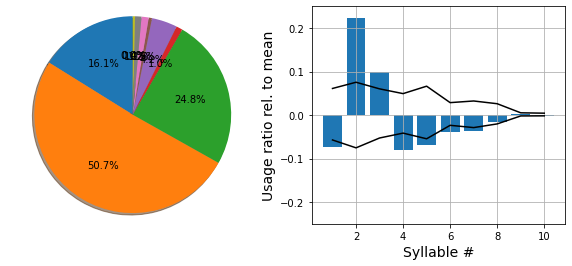

In [563]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].pie(syl_ratios_succ.sum(axis=0), autopct='%1.1f%%', shadow=True, startangle=90, normalize=True, colors=colors)
axes[0].axis('equal')

syll_sums  = syl_ratios_succ.sum(axis=0)/len(syl_ratios_succ)
syll_means = syl_ratio_matrix.mean(axis=0)

x_vals = np.arange(syl_ratio_matrix.shape[1]) + 1
axes[1].bar(x_vals, syll_sums - shuffled_mean)
axes[1].plot(x_vals, confidence_low - shuffled_mean, color='black')
axes[1].plot(x_vals, confidence_high - shuffled_mean, color='black')
axes[1].set_ylim(-0.25, 0.25)
axes[1].set_xlabel('Syllable #', fontsize=14)
axes[1].set_ylabel('Usage ratio rel. to mean', fontsize=14)
axes[1].grid()

Text(0, 0.5, 'Syllable ratios, %')

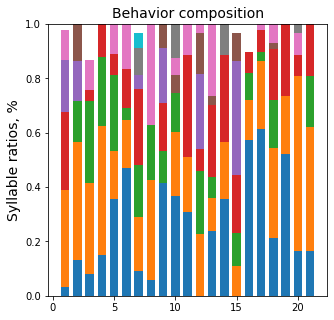

In [513]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

bottom = np.zeros(len(idxs_tl_succ))
for i, syl_ratio in enumerate(syl_ratios_succ.T):
    ax.bar(np.arange(len(syl_ratio)) + 1, syl_ratio, 0.7, bottom=bottom, label='Syll. # %s' % str(i+1))
    bottom += syl_ratio
ax.set_title('Behavior composition', fontsize=14)
ax.set_ylabel('Syllable ratios, %', fontsize=14)
#ax.legend(loc='upper right')

## Syllable proportion in diff states

In [27]:
idxs_filt = np.where((tl[:, 0] < 600) | (tl[:, 0] > 1800))[0]  # light filter
idxs_filt = np.where((tl[:, 0] > 0))[0]  # no filter

probs = []

act_list = np.zeros(len(i_rate))
act_list[i_rate > thresh] = 1
idxs_active  = np.where(act_list == 1)[0]
idxs_passive = np.where(act_list == 0)[0]
    
for syllable in np.unique(syls):
    syl1 = np.zeros(len(syls))
    syl1[np.where(syls == syllable)[0]] = 1
    syl_interp = np.interp(tl[:, 0], syls_t, syl1)
    
    idxs_syl1 = np.where(syl_interp == 1)[0]

    idxs_syl_active  = reduce(np.intersect1d, (idxs_syl1, idxs_active, idxs_filt))
    idxs_syl_passive = reduce(np.intersect1d, (idxs_syl1, idxs_passive, idxs_filt))

    p_syl_active  = len(idxs_syl_active)  / len( np.intersect1d(idxs_active, idxs_filt) )
    p_syl_passive = len(idxs_syl_passive) / len( np.intersect1d(idxs_passive, idxs_filt))
    #p_syl = len(np.intersect1d(idxs_syl1, idxs_light)) / len(idxs_light)

    probs.append([p_syl_active, p_syl_passive])
    
probs = np.array(probs)

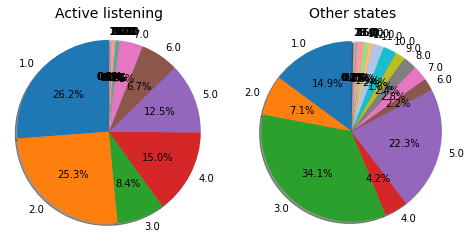

In [28]:
max_syl = 20

labels  = np.unique(syls)[:max_syl]
sizes_active  = probs[:, 0][:max_syl]
sizes_passive = probs[:, 1][:max_syl]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(sizes_active, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, normalize=False, colors=colors)
ax1.axis('equal')
ax1.set_title('Active listening', fontsize=14)

ax2 = fig.add_subplot(1, 2, 2)
ax2.pie(sizes_passive, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, normalize=False, colors=colors)
ax2.axis('equal')
ax2.set_title('Other states', fontsize=14)

fig.savefig(os.path.join(source, 'behav_comp_pie_%s.png' % session[:26]))

## Syllable occurence

In [52]:
probabilities = []
coeffs = []
#idxs_actl = np.where(i_rate > 6.5)[0]
    
for syllable in np.unique(syls)[:20]:

    syl1 = np.zeros(len(syls))
    syl1[np.where(syls == syllable)[0]] = 1
    syl_interp = np.interp(tl[:, 0], syls_t, syl1)

    idxs_syl1 = np.where(syl_interp == 1)[0]
    i_sect = np.intersect1d(idxs_syl1, idxs_actl)

    coeffs.append(len(np.where(syls == syllable)[0]) / len(syls))
    probabilities.append(0 if len(idxs_syl1) == 0 else len(i_sect)/len(idxs_syl1))

NameError: name 'idxs_actl' is not defined

NameError: name 'syls' is not defined

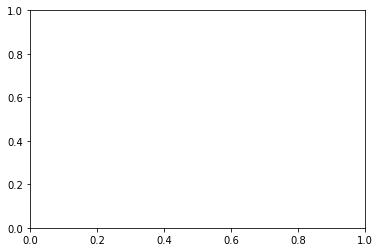

In [151]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(np.unique(syls)[:20], probabilities, width=5*np.array(coeffs))
ax.axhline(0.5, ls='--')
ax.set_xlabel('Syllable #', fontsize=14)
ax.set_ylabel('Probability dur. Active listening #', fontsize=14)